## 베팅전략1 - 켈리베팅
---
### 목적
    
    이길 확률을 알고 있는 상황이라고 가정하면, 수익극대화를 위해 얼마를 베팅해야 할까?  
    이길 확률을 모르는 상황이라면, 어떻게 이길확률을 추론할 수 있을까?
    
### 수식

#### 이진베팅(상승/하락)의 경우
    베팅비율 = 기대수익(률)/상승시 수익(률)

#### 주가수익률의 경우
    베팅비율 = 전체 수익률분포함수로부터 계산된 기대수익률/상승시의 기대수익률

### 수학적 의미

투자자산의 수익률이 정규분포를 따를 경우, 샤프 지수를 극대화하는 것은 켈리공식에 따라 투자하는 것과 같은 결과를 가져온다.

## 켈리베팅 베팅사이즈 계산 예시

종목 : 현대자동차(단일종목)  
대상 : 당일종가-익일종가 수익률  
기간 : 1997-현재시점까지의 모든 날짜 수익률을 사용

In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr 
import seaborn as sns

In [2]:
#기하평균 계산 함수
def geo_mean(iterable): 
    a = np.array(iterable)
    a = a[~np.isnan(a)]
    if len(a) != 0 :
        return a.prod()**(1.0/len(a))
    else : return None
    
def geo_mean_overflow(iterable):
    a = np.log(iterable)
    a = a[~np.isnan(a)]
    return np.exp(a.sum()/len(a))

In [4]:
#현대자동차의 주식데이터 받아오기
ticker = {'삼성전자':'005930','KOSPI':'KS11','현대차':'005380','기아차':'000270','엔씨':'036570'}

df = fdr.DataReader(ticker['현대차'], '1997')
df['Change_pos'] = df[df['Change']>=0]['Change']
#df['Change_pos'] = df['Change_pos'].fillna(0)
df.head(10)

,Open,High,Low,Close,Volume,Change,Change_pos
Date,,,,,,,
1997-01-03,12937,13002,12417,13001,32390,0.030925,0.030925
1997-01-04,13132,13392,13002,13001,33410,0.000000,0.000000
1997-01-06,12677,13002,12677,13001,14770,0.000000,0.000000
1997-01-07,13002,13587,13002,13001,15280,0.000000,0.000000
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075
1997-01-09,13327,14237,13197,14107,14070,0.058528,0.058528
1997-01-10,14172,14627,13912,14302,61530,0.013823,0.013823
1997-01-11,13977,14497,13652,14497,43400,0.013634,0.013634
1997-01-13,14627,14822,14627,14757,30970,0.017935,0.017935


1. 수익률분포 확인 및 정규성 검정

https://datascienceschool.net/view-notebook/14bde0cc05514b2cae2088805ef9ed52/

In [5]:
import scipy
import statsmodels

count    5855.000000
mean        0.000761
std         0.028945
min        -0.149660
25%        -0.014430
50%         0.000000
75%         0.014493
max         0.150000
Name: Change, dtype: float64


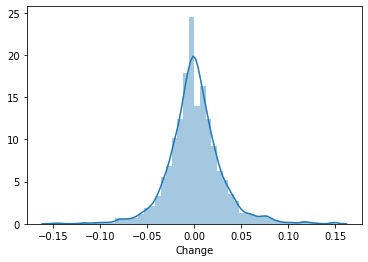

In [6]:
#주가수익률의 분포 확인
print(df['Change'].describe())
sns.distplot(df['Change'])

In [7]:
#주가수익률의 정규성 검정
#p<0.05이므로 H0 : 정규분포 기각
scipy.stats.shapiro(df['Change'])

C:\Users\KMS\Anaconda3\envs\data37\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9524521827697754, 5.7686693361474014e-40)

2. 전체 구간 Kelly Size  계산

In [8]:
# 기대수익률 = 수익률의 기하평균
# 확률밀도 전체의 기대수익률 추정
exp_mean = geo_mean(df.Change + 1) - 1
# 상승마감시의 기대수익률 추정
exp_mean_pos =  geo_mean(df.Change_pos + 1) -1

print("전체 기대수익률 : ",exp_mean)
print("상승시의 기대수익률 : ",exp_mean_pos)

전체 기대수익률 :  0.00034404386388753316
상승시의 기대수익률 :  0.01970243499866231


In [9]:
#베팅사이즈 결정
betting_size = exp_mean/exp_mean_pos
print("베팅사이즈 : ",betting_size)

베팅사이즈 :  0.017461997154711684


## 단일종목 켈리베팅을 통한 백테스팅 예시 2

오버나잇 전략의 켈리베팅 적용 수익률 벡테스팅

종목 : 현대자동차
시작자금 : 원화 현금 10,000,000  
베팅사이즈 : 해당일 이전 전체기간의 수익률 이용한 켈리베팅  
매수조건 : 당일 종가 매수  
매도조건 : 익일 시가 매도  

공매도 여부 : 한국주식은 공매도가 불가하므로, 배팅사이즈가 <0인 경우는 베팅하지 않는다

1. 데이터 받아오기 및 전략 수익률 계산

In [12]:
#현대자동차의 주식데이터 받아오기
ticker = {'삼성전자':'005930','KOSPI':'KS11','현대차':'005380','기아차':'000270','엔씨':'036570'}

df = fdr.DataReader(ticker['현대차'], '1997')
df = df.drop('Change',axis=1)
df['Return'] = (df['Open'] - df['Close'].shift(1))/(df['Close'].shift(1))
df['Return_pos'] = df[df['Return']>=0]['Return']

df.head(10)

,Open,High,Low,Close,Volume,Return,Return_pos
Date,,,,,,,
1997-01-03,12937,13002,12417,13001,32390,NaN,NaN
1997-01-04,13132,13392,13002,13001,33410,0.010076,0.010076
1997-01-06,12677,13002,12677,13001,14770,-0.024921,NaN
1997-01-07,13002,13587,13002,13001,15280,0.000077,0.000077
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075
1997-01-09,13327,14237,13197,14107,14070,0.000000,0.000000
1997-01-10,14172,14627,13912,14302,61530,0.004608,0.004608
1997-01-11,13977,14497,13652,14497,43400,-0.022724,NaN
1997-01-13,14627,14822,14627,14757,30970,0.008967,0.008967


In [13]:
#맨 첫줄 NaN데이터 제거
df = df[1:]

2. 켈리베팅 사이즈 계산

In [14]:
%%time

#해당일이전 전기간 기준 켈리사이즈 계산
for index in df.index :
    exp_mean = geo_mean(df.Return.loc[:index] + 1) - 1
    exp_mean_pos =  geo_mean(df.Return_pos.loc[:index] + 1) -1
    df.loc[index,'기대수익률'] = exp_mean
    df.loc[index,'상승 기대수익률'] = exp_mean_pos
    df.loc[index,'BtRate'] = exp_mean/exp_mean_pos

In [16]:
#해당일이전 52주 기준 켈리사이즈 계산
for index in df.index :
    id_num =df.index.get_loc(index)
    if id_num >= 252 :
        exp_mean = geo_mean(df.Return.iloc[id_num-252:id_num] + 1) - 1
        exp_mean_pos =  geo_mean(df.Return_pos.iloc[id_num-252:id_num] + 1) -1
        df.loc[index,'52주 기대수익률'] = exp_mean
        df.loc[index,'52주 상승 기대수익률'] = exp_mean_pos
        df.loc[index,'52주 BtRate'] = exp_mean/exp_mean_pos

In [17]:
df.tail()

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,BtRate,52주 기대수익률,52주 상승 기대수익률,52주 BtRate
Date,,,,,,,,,,,,,
2020-04-29,93500,94000,92400,93600,1193284,0.003219,0.003219,0.000258,0.009272,0.027845,-0.000135,0.006922,-0.019575
2020-05-04,91100,92900,90700,91500,1264378,-0.026709,NaN,0.000254,0.009272,0.027341,-0.000123,0.006944,-0.017677
2020-05-06,93300,94200,92600,93200,1039600,0.019672,0.019672,0.000257,0.009275,0.027687,-0.000317,0.006841,-0.046293
2020-05-07,92800,93000,91800,92600,826239,-0.004292,NaN,0.000256,0.009275,0.027603,-0.000239,0.006975,-0.034327
2020-05-08,93000,95400,93000,94500,1738255,0.004320,0.004320,0.000257,0.009274,0.027682,-0.000256,0.007023,-0.036522


In [18]:
#베팅비율이 양수인 경우만 체크
df['BtRate_pos'] = df[df['BtRate']>=0]['BtRate']
df['BtRate_pos'] = df['BtRate_pos'].fillna(0)
df = df.drop('BtRate',axis=1)
df.head()

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,52주 기대수익률,52주 상승 기대수익률,52주 BtRate,BtRate_pos
Date,,,,,,,,,,,,,
1997-01-04,13132,13392,13002,13001,33410,0.010076,0.010076,0.010076,0.010076,NaN,NaN,NaN,1.000000
1997-01-06,12677,13002,12677,13001,14770,-0.024921,NaN,-0.007577,0.010076,NaN,NaN,NaN,0.000000
1997-01-07,13002,13587,13002,13001,15280,0.000077,0.000077,-0.005032,0.005064,NaN,NaN,NaN,0.000000
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075,0.002411,0.011691,NaN,NaN,NaN,0.206214
1997-01-09,13327,14237,13197,14107,14070,0.000000,0.000000,0.001928,0.008755,NaN,NaN,NaN,0.220229


In [19]:
#52주 비율이 양수인 경우만 체크
df['52주 BtRate_pos'] = df[df['52주 BtRate']>=0]['52주 BtRate']
df['52주 BtRate_pos'] = df['52주 BtRate_pos'].fillna(0)
df = df.drop('52주 BtRate',axis=1)

In [20]:
df.tail()

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,52주 기대수익률,52주 상승 기대수익률,BtRate_pos,52주 BtRate_pos
Date,,,,,,,,,,,,,
2020-04-29,93500,94000,92400,93600,1193284,0.003219,0.003219,0.000258,0.009272,-0.000135,0.006922,0.027845,0.0
2020-05-04,91100,92900,90700,91500,1264378,-0.026709,NaN,0.000254,0.009272,-0.000123,0.006944,0.027341,0.0
2020-05-06,93300,94200,92600,93200,1039600,0.019672,0.019672,0.000257,0.009275,-0.000317,0.006841,0.027687,0.0
2020-05-07,92800,93000,91800,92600,826239,-0.004292,NaN,0.000256,0.009275,-0.000239,0.006975,0.027603,0.0
2020-05-08,93000,95400,93000,94500,1738255,0.004320,0.004320,0.000257,0.009274,-0.000256,0.007023,0.027682,0.0


3. 켈리베팅 적용 전략 수익률 계산

In [21]:
#자산, 배팅액수 초기화
df['Asset_open'] = 0
df['BtSize'] = 0
df['Residual'] = 0

In [22]:
#BtSize는 당일 Asset_Open * BtRate
#Residual은 Asset_Open *(1-BtRate)
#다음날 Asset_open = 이전일 Btsize*당일 Return + 이전일 Residual
#어쩔수 없이 for문 돌아야 함

In [23]:
for index in df.index :
    if df.index.get_loc(index) == 0 : #첫번째 행일 경우
        df.loc[index,'Asset_open'] = 10000000
        df.loc[index,'BtSize'] = df.loc[index,'Asset_open']*df.loc[index,'BtRate_pos']
        df.loc[index,'Residual'] = df.loc[index,'BtSize']-df.loc[index,'Asset_open']
    else :
        #이전일자 정보를 저장하는 Series Copy 생성
        day_before = df.iloc[df.index.get_loc(index)-1] 
        
        #Copy로부터 결과를 원본 DF에 덮어씀
        df.loc[index,'Asset_open'] = day_before['Residual'] + day_before['BtSize']*(1+df.loc[index,'Return'])
        day_now = df.iloc[df.index.get_loc(index)] 
        
        df.loc[index,'BtSize'] = day_now['Asset_open']*day_now['BtRate_pos']
        #위에걸로 하면 값 이상하고, 아래걸로 하면 정상동작하는데 확인 필요
        #df.loc[index,'Residual'] = day_now['Asset_open'] - day_now['BtSize']
        df.loc[index,'Residual'] = day_now['Asset_open']*(1-day_now['BtRate_pos'])
        print(df.loc[index,'BtSize'], day_now['BtSize'])

0.0 0.0
0.0 0.0
2010748.2409401098 0.0
2147404.4335712497 0.0
2924431.0023102714 0.0
0.0 0.0
25387.60249847127 0.0
0.0 0.0
786122.8858732568 0.0
817194.9359520802 0.0
843086.8187386307 0.0
864994.2671073467 0.0
1654769.77450487 0.0
1685258.90586007 0.0
317278.49415341334 0.0
323573.46324669244 0.0
329168.93877052754 0.0
0.0 0.0
0.0 0.0
0.0 0.0
708478.4480436128 0.0
1648732.2387302143 0.0
2565803.1820246642 0.0
2593110.657698522 0.0
2984441.03215117 0.0
2352561.7314663124 0.0
2376816.0446811025 0.0
2399396.5952209886 0.0
2420470.8604677767 0.0
2623269.036937872 0.0
3274413.679304794 0.0
3567287.5269978726 0.0
3837055.0628114776 0.0
3860798.7060732916 0.0
3883221.916000413 0.0
3904431.8603665396 0.0
3924524.4153356296 0.0
4060753.3923715404 0.0
4079400.729582076 0.0
4097137.5822925884 0.0
4664909.973070072 0.0
4683181.5625196 0.0
5663381.505689027 0.0
5753115.416156946 0.0
5772578.895771103 0.0
5924941.087714283 0.0
5943213.111695461 0.0
5960738.117057222 0.0
5977560.996680104 0.0
599372

230747.17687177283 0.0
212701.32603584812 0.0
225880.11502512236 0.0
319232.70203894656 0.0
373709.7923202499 0.0
381359.7864241424 0.0
385450.16191575315 0.0
400256.92286177893 0.0
415447.6234271611 0.0
374591.2676506775 0.0
412151.51338950475 0.0
379370.4016952856 0.0
379791.6465027661 0.0
409426.5710497016 0.0
424191.98692434496 0.0
369595.7590669827 0.0
353225.34085303324 0.0
336243.6021664124 0.0
358957.28381212254 0.0
387666.9021908537 0.0
493386.1104256333 0.0
493923.7339675088 0.0
494459.4705948924 0.0
495078.5060081952 0.0
536969.982617711 0.0
543304.826496867 0.0
535680.5924439278 0.0
545770.1182253296 0.0
577853.2069626292 0.0
562466.1985610899 0.0
576188.1031162261 0.0
628456.1475084571 0.0
600376.2270441159 0.0
643379.3783218733 0.0
661642.0113966916 0.0
685642.7447434666 0.0
763830.0794839056 0.0
764692.3132587817 0.0
770377.4542501499 0.0
763979.8641493558 0.0
736776.7873361495 0.0
747213.3542992986 0.0
762240.9666873852 0.0
715917.469425514 0.0
686474.4683423506 0.0
692

1003716.8267361608 0.0
1006648.5432459549 0.0
971169.1710006108 0.0
982410.089674589 0.0
996079.5785207188 0.0
996706.5071732431 0.0
997332.1234784599 0.0
997956.4315524598 0.0
998579.4354943857 0.0
999201.1393861879 0.0
1002234.1470076913 0.0
998372.8356320508 0.0
973959.5955485712 0.0
974564.8267731988 0.0
994979.8074442176 0.0
976159.0245840664 0.0
976763.4411232227 0.0
977366.6068534612 0.0
958155.5657564604 0.0
925279.8972513464 0.0
897967.8740777376 0.0
904017.739929913 0.0
878802.2254893712 0.0
862846.7510920134 0.0
865829.4958850833 0.0
873594.5843356372 0.0
881298.9213162798 0.0
863930.5080763265 0.0
804198.4933832957 0.0
791835.2149098787 0.0
816519.9120117541 0.0
821293.7897294422 0.0
808706.1856120992 0.0
844164.2028482218 0.0
829049.7565023791 0.0
813769.3757347217 0.0
832468.7947257082 0.0
805438.2100189424 0.0
795000.3813816388 0.0
802112.2949550025 0.0
793818.1790321564 0.0
787970.7665770799 0.0
788456.9995706901 0.0
809956.013464207 0.0
810453.2077301757 0.0
807269.247

372417.5748323295 0.0
375427.67634150153 0.0
366032.6217731554 0.0
361150.5751410575 0.0
367409.22090954345 0.0
365734.9886781779 0.0
364779.1716599286 0.0
367474.39372467593 0.0
367653.2853129628 0.0
367831.9158891229 0.0
368010.2860240645 0.0
374607.4466740924 0.0
376088.3755697989 0.0
368634.4602406898 0.0
374000.89402742364 0.0
379181.51168785937 0.0
389385.03884117934 0.0
390808.02682846575 0.0
390995.2036642993 0.0
381024.2257572505 0.0
369516.9850261255 0.0
361955.16116205533 0.0
373462.849438169 0.0
365462.4066099522 0.0
371985.38667204144 0.0
369719.471991528 0.0
384866.1437542475 0.0
387334.04423369677 0.0
403084.4198444942 0.0
403276.3333356208 0.0
406493.3185412651 0.0
411860.5430027318 0.0
416158.1874968683 0.0
416354.82104045333 0.0
408874.84526306676 0.0
409067.8808959122 0.0
374924.9248429791 0.0
377224.13890568435 0.0
397322.25636778615 0.0
397508.98725462984 0.0
397695.45171067805 0.0
379747.3757193599 0.0
385650.94740496494 0.0
399203.647575203 0.0
394887.0393182669 

135737.92542043922 0.0
128516.7209205725 0.0
129713.01620459135 0.0
133033.84984128288 0.0
140510.10814820597 0.0
140566.86516897194 0.0
141662.29606561223 0.0
141719.34326096022 0.0
147832.28131038893 0.0
145797.60762915664 0.0
141921.7575617404 0.0
152895.0457156836 0.0
148389.4756755469 0.0
141361.6816471264 0.0
141418.52923055415 0.0
149758.27922190772 0.0
140879.19884632676 0.0
134743.74572068185 0.0
137543.75788577014 0.0
122712.72768772821 0.0
120662.97844092618 0.0
120095.99791145611 0.0
118064.43090589906 0.0
129818.65689121709 0.0
136973.90344883507 0.0
139731.17846578907 0.0
144319.05133656773 0.0
146155.24175420761 0.0
152167.95391241627 0.0
148608.5998907316 0.0
148091.07406258336 0.0
146229.2696684365 0.0
137928.93560548156 0.0
145783.53175067468 0.0
137185.39197707933 0.0
135817.53711413415 0.0
145792.49516810747 0.0
151553.77574280492 0.0
143117.17786501022 0.0
148014.52564676208 0.0
146647.8251020027 0.0
149910.68716126969 0.0
148584.89060446958 0.0
153553.11862697874 

236721.51490428887 0.0
233283.60301466388 0.0
231194.64682354854 0.0
231908.10416629742 0.0
234503.2813298879 0.0
237753.2356017954 0.0
241556.63931355425 0.0
242869.59816792104 0.0
246649.06752420668 0.0
244608.78195802582 0.0
244689.45103781208 0.0
241993.92277947432 0.0
236082.667759856 0.0
230723.0397416322 0.0
227985.51093321698 0.0
228686.0376403871 0.0
226620.49731444367 0.0
229206.05287254398 0.0
236025.70599492284 0.0
239722.24172469432 0.0
245731.42155869608 0.0
244406.61829000246 0.0
246185.48345380687 0.0
255188.66083822167 0.0
258078.84574878527 0.0
257363.506906561 0.0
262992.3352465472 0.0
266324.61746023956 0.0
266961.40753483295 0.0
267604.3703426717 0.0
265227.9400900671 0.0
269534.5430468498 0.0
256971.9062414307 0.0
257606.4787328019 0.0
256919.2049590345 0.0
257002.91106658627 0.0
260832.92375996153 0.0
265712.10799274663 0.0
265061.9107938182 0.0
263351.7500156167 0.0
263437.3447433632 0.0
266032.24563684245 0.0
258384.77505011682 0.0
256646.73227750167 0.0
256010

120722.71686381793 0.0
122325.34168630642 0.0
120675.46609974102 0.0
123765.66780496477 0.0
127372.4225283513 0.0
126272.3629445886 0.0
125156.87519708702 0.0
122989.89330657528 0.0
126613.16237923305 0.0
131593.27701345255 0.0
126378.31474322682 0.0
126916.41687190486 0.0
129462.48505973052 0.0
129998.32983685921 0.0
129439.66503186034 0.0
132405.26336225396 0.0
132920.19115489346 0.0
132957.97104614318 0.0
132995.72167264554 0.0
131953.13744895285 0.0
129882.80845538832 0.0
126309.05985650542 0.0
122775.47545747554 0.0
128101.37445682233 0.0
132858.42920789015 0.0
136196.2501670389 0.0
138087.29654303595 0.0
143124.21002141418 0.0
144527.21114089168 0.0
143058.85908150958 0.0
138721.37326747962 0.0
139228.66347254917 0.0
128844.45305666533 0.0
126327.58126646934 0.0
121815.15735389008 0.0
123788.45435223459 0.0
126227.14605090504 0.0
123197.72973674418 0.0
126164.2516474341 0.0
127666.485546554 0.0
128666.73701437772 0.0
123141.86343131812 0.0
124638.81012853148 0.0
126607.7132047619

246321.6976678974 0.0
247230.5619110972 0.0
231857.45705378 0.0
238225.00780756737 0.0
238282.6452507707 0.0
236054.61005423893 0.0
234638.00976774245 0.0
237295.07508887752 0.0
204625.96126728115 0.0
211470.26018869836 0.0
203553.04276567075 0.0
212443.31520697867 0.0
214206.6486762564 0.0
214258.33854714726 0.0
212913.62266220537 0.0
208600.01743962764 0.0
208650.35561588377 0.0
209112.9920021488 0.0
194151.48079205133 0.0
197043.48794255313 0.0
196556.09255698993 0.0
188748.31420001385 0.0
186922.9005410652 0.0
178610.14771244125 0.0
181597.08891739522 0.0
172785.00724891014 0.0
169113.9492682722 0.0
176927.26593727674 0.0
172433.03481991764 0.0
159794.0400763105 0.0
171158.31546534455 0.0
179906.42065952372 0.0
180442.00539007268 0.0
175614.97385092356 0.0
162436.0175179946 0.0
163062.1782037439 0.0
163101.41063989882 0.0
148171.43669991495 0.0
162213.79585059843 0.0
188013.62007273847 0.0
182100.1670197959 0.0
188120.8332760777 0.0
184848.2825488126 0.0
193854.69255800173 0.0
1801

399169.1954928744 0.0
395363.5859181536 0.0
398867.62517049926 0.0
401163.5216083047 0.0
401247.1514088724 0.0
412020.84770599176 0.0
413157.5260431284 0.0
410808.1020647973 0.0
402742.7109462661 0.0
401516.8671688565 0.0
401600.4773724816 0.0
400420.08443311666 0.0
405528.3096508704 0.0
396874.89429862396 0.0
387067.9488089975 0.0
387148.52446935937 0.0
391361.97931098123 0.0
393518.51165508246 0.0
398628.44046986813 0.0
397486.4419638235 0.0
393340.7646972751 0.0
393422.4552558742 0.0
387933.84162247874 0.0
388981.4591077109 0.0
383659.11207467556 0.0
377254.8733455198 0.0
372881.017134436 0.0
368531.97321565944 0.0
372519.7146905571 0.0
371367.966145065 0.0
368180.19782121526 0.0
372295.614962525 0.0
370013.29199192976 0.0
362357.7894894078 0.0
362433.09083248687 0.0
363474.2962134131 0.0
363549.70977247105 0.0
368546.6988054342 0.0
370574.5284217305 0.0
372541.7383858171 0.0
374458.306420922 0.0
373368.3095301999 0.0
374372.9602829344 0.0
379074.1478571207 0.0
375006.45597984584 0.

371093.8122593732 0.0
374753.07508348103 0.0
375404.24476846185 0.0
385344.2868199324 0.0
377898.69482486125 0.0
380232.930267817 0.0
381992.7567073179 0.0
382063.86409379105 0.0
383242.94354182377 0.0
377694.0129079918 0.0
383527.48611386225 0.0
379741.7364235868 0.0
379006.92083768087 0.0
373758.038416359 0.0
373827.5695470734 0.0
373089.94571428734 0.0
375585.5262986355 0.0
383371.1209480806 0.0
382643.13695494505 0.0
386222.05759837746 0.0
386877.89033194707 0.0
386949.6612465735 0.0
387021.3943810101 0.0
385662.7279234274 0.0
386912.1701814989 0.0
389926.796573078 0.0
392824.50308592914 0.0
394021.4528412814 0.0
394657.20003352413 0.0
395303.41105690115 0.0
394594.3003516765 0.0
395222.6789710558 0.0
396955.50422798225 0.0
397028.67907547695 0.0
399309.21862249816 0.0
403810.4443282665 0.0
404430.58598352503 0.0
406175.6664473869 0.0
406250.27702075685 0.0
406868.8343072517 0.0
408021.3524481976 0.0
406736.9580746979 0.0
402341.5504779873 0.0
404741.3372348487 0.0
404815.530418713

449672.2903348133 0.0
451940.4905454507 0.0
454205.4418971258 0.0
454280.3340739049 0.0
453583.8538075826 0.0
451133.7803436719 0.0
449864.21950246376 0.0
451014.99875670014 0.0
452671.72844587086 0.0
454788.76992463897 0.0
457470.43133336277 0.0
461725.27796526736 0.0
462853.3354891068 0.0
466088.3417281894 0.0
461439.87668264384 0.0
463136.83822941885 0.0
465373.3744796581 0.0
466000.3870950375 0.0
469372.3501661883 0.0
468104.15715277975 0.0
468180.88482576754 0.0
465846.9539226289 0.0
462935.23217934475 0.0
463011.11667957203 0.0
461755.94661205175 0.0
462898.3549666488 0.0
464039.0021444353 0.0
464629.0084004897 0.0
460651.25262357685 0.0
461737.5269328847 0.0
463840.21867677546 0.0
461625.3119568361 0.0
462695.18652534334 0.0
462046.9250724449 0.0
462624.17434205074 0.0
465678.7132227829 0.0
466240.9833941139 0.0
468276.8742215487 0.0
468353.20423870155 0.0
466656.06622086966 0.0
466732.10987559817 0.0
469251.1586598437 0.0
469804.8298049094 0.0
457730.65334285225 0.0
459705.1972

495526.9266542089 0.0
494681.69630280737 0.0
497545.45974676445 0.0
494475.9806710418 0.0
495888.66417649924 0.0
498021.56122866017 0.0
498784.6463374478 0.0
502217.2173128084 0.0
503593.9611668867 0.0
508840.8059335657 0.0
510207.0360787034 0.0
511595.4392607752 0.0
510767.10230597836 0.0
508451.8687868395 0.0
506075.16948341887 0.0
507552.74652242946 0.0
509043.7966225614 0.0
513358.2575423912 0.0
511721.57483081473 0.0
513965.3385344583 0.0
517647.5085754777 0.0
518441.77700705075 0.0
519254.06988423015 0.0
520804.55126059655 0.0
520882.095258854 0.0
522433.8324164664 0.0
524642.3471961586 0.0
525435.1322433567 0.0
528987.3529589119 0.0
529769.180652786 0.0
528122.3121972114 0.0
524957.6358475689 0.0
524105.0488472629 0.0
522482.67995732947 0.0
525353.2240114905 0.0
528812.6511834756 0.0
531572.3199549781 0.0
532330.2861011092 0.0
530714.3039432089 0.0
529844.1630840321 0.0
531333.8985502507 0.0
530467.9989100139 0.0
528846.0882033131 0.0
527986.3528504407 0.0
530811.2170352142 0.0


498967.7373512612 0.0
499036.4344374241 0.0
498015.9495010231 0.0
500655.55249945953 0.0
501585.03347821103 0.0
501653.99981868005 0.0
502584.0162040632 0.0
503520.98134752235 0.0
505304.37861418 0.0
506226.429555307 0.0
505228.33334670326 0.0
507791.6691990026 0.0
507861.2847146852 0.0
505108.2407498598 0.0
506812.68574189476 0.0
505836.9530474842 0.0
505906.26690314076 0.0
505975.55300566123 0.0
508566.3815459801 0.0
509473.7787628669 0.0
508477.52181481395 0.0
510257.0453692091 0.0
512103.99349297286 0.0
513047.7576805398 0.0
512005.3429651953 0.0
512075.28045589733 0.0
512145.18999386963 0.0
511103.4046730627 0.0
512059.97774914245 0.0
512129.83082896116 0.0
513918.3917567409 0.0
512889.6514617325 0.0
513810.8309360045 0.0
511880.9167614406 0.0
508089.88495271874 0.0
506146.831483039 0.0
506215.8482116197 0.0
509739.05150764895 0.0
511523.87920828554 0.0
514154.58129819174 0.0
516741.23013572925 0.0
520164.845799625 0.0
520235.5478402846 0.0
523490.1712591602 0.0
523561.24955842947

379121.16899200535 0.0
377538.4713337147 0.0
376716.4237512002 0.0
373607.1455536265 0.0
372758.814651965 0.0
371886.01625998097 0.0
371934.13755896577 0.0
373509.41736130056 0.0
371021.55764606496 0.0
373371.73680710286 0.0
372493.30045983056 0.0
372541.45396621485 0.0
373330.19385948585 0.0
372471.750580343 0.0
371613.90931569145 0.0
369949.14318839944 0.0
370755.1175695437 0.0
367474.96519758925 0.0
369085.075286119 0.0
369921.5572553544 0.0
368187.9502739394 0.0
366411.7928342747 0.0
366459.1179468294 0.0
364624.0022082568 0.0
363695.5819657028 0.0
361891.1594543025 0.0
360961.25163866626 0.0
358257.48097662424 0.0
357298.84932244 0.0
356344.4821167804 0.0
359776.18546427955 0.0
356956.9262390589 0.0
355958.7647456104 0.0
357730.47796659835 0.0
358627.60234286886 0.0
356768.1361163555 0.0
352162.6331046333 0.0
352208.16062742594 0.0
353106.42038747115 0.0
353152.02442627016 0.0
353197.6116072306 0.0
354072.82726135966 0.0
355808.4061065285 0.0
356701.16645355325 0.0
357574.27226923

300088.5485894677 0.0
300943.20565801713 0.0
301801.4679048685 0.0
299156.8856763374 0.0
299193.3915029533 0.0
300061.21834792825 0.0
300946.88915411144 0.0
300983.5618848329 0.0
301884.2132236426 0.0
300918.7142483634 0.0
302740.74707246077 0.0
304571.51637230424 0.0
304608.5706845338 0.0
305517.5889293904 0.0
305554.72361261165 0.0
309059.31269666465 0.0
309096.8428960522 0.0
310825.15621412307 0.0
310862.86565080483 0.0
311758.8884153558 0.0
316498.82819876494 0.0
310701.5090047159 0.0
312268.7025014935 0.0
310597.70288840216 0.0
312206.23600575165 0.0
308751.0785609129 0.0
308788.477270419 0.0
310439.9162580762 0.0
312894.67061415565 0.0
310430.4512014032 0.0
307950.93499003537 0.0
309526.647865292 0.0
309564.08942645777 0.0
311072.95724851656 0.0
310225.59930594155 0.0
310263.0997697256 0.0
307865.52738114377 0.0
308658.6138637325 0.0
310216.68489017215 0.0
306900.0741135397 0.0
301023.94984167226 0.0
301060.3143639296 0.0
298424.79082817415 0.0
298460.8335028861 0.0
294037.621395

In [24]:
df.head(10)

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,52주 기대수익률,52주 상승 기대수익률,BtRate_pos,52주 BtRate_pos,Asset_open,BtSize,Residual
Date,,,,,,,,,,,,,,,,
1997-01-04,13132,13392,13002,13001,33410,0.010076,0.010076,0.010076,0.010076,NaN,NaN,1.000000,0.0,1.000000e+07,1.000000e+07,0.000000e+00
1997-01-06,12677,13002,12677,13001,14770,-0.024921,NaN,-0.007577,0.010076,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06
1997-01-07,13002,13587,13002,13001,15280,0.000077,0.000077,-0.005032,0.005064,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075,0.002411,0.011691,NaN,NaN,0.206214,0.0,9.750788e+06,2.010748e+06,7.740040e+06
1997-01-09,13327,14237,13197,14107,14070,0.000000,0.000000,0.001928,0.008755,NaN,NaN,0.220229,0.0,9.750788e+06,2.147404e+06,7.603384e+06
1997-01-10,14172,14627,13912,14302,61530,0.004608,0.004608,0.002374,0.007924,NaN,NaN,0.299613,0.0,9.760683e+06,2.924431e+06,6.836252e+06
1997-01-11,13977,14497,13652,14497,43400,-0.022724,NaN,-0.001250,0.007924,NaN,NaN,0.000000,0.0,9.694228e+06,0.000000e+00,9.694228e+06
1997-01-13,14627,14822,14627,14757,30970,0.008967,0.008967,0.000021,0.008098,NaN,NaN,0.002619,0.0,9.694228e+06,2.538760e+04,9.668840e+06
1997-01-14,14627,15927,14627,15927,64990,-0.008809,NaN,-0.000964,0.008098,NaN,NaN,0.000000,0.0,9.694004e+06,0.000000e+00,9.694004e+06


In [25]:
#투자결과 수익률 계산
df['KellyReturn'] = (df['Asset_open'] - df['Asset_open'].shift(1))/df['Asset_open'].shift(1)
df.head(10)

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,52주 기대수익률,52주 상승 기대수익률,BtRate_pos,52주 BtRate_pos,Asset_open,BtSize,Residual,KellyReturn
Date,,,,,,,,,,,,,,,,,
1997-01-04,13132,13392,13002,13001,33410,0.010076,0.010076,0.010076,0.010076,NaN,NaN,1.000000,0.0,1.000000e+07,1.000000e+07,0.000000e+00,NaN
1997-01-06,12677,13002,12677,13001,14770,-0.024921,NaN,-0.007577,0.010076,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06,-0.024921
1997-01-07,13002,13587,13002,13001,15280,0.000077,0.000077,-0.005032,0.005064,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06,0.000000
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075,0.002411,0.011691,NaN,NaN,0.206214,0.0,9.750788e+06,2.010748e+06,7.740040e+06,0.000000
1997-01-09,13327,14237,13197,14107,14070,0.000000,0.000000,0.001928,0.008755,NaN,NaN,0.220229,0.0,9.750788e+06,2.147404e+06,7.603384e+06,0.000000
1997-01-10,14172,14627,13912,14302,61530,0.004608,0.004608,0.002374,0.007924,NaN,NaN,0.299613,0.0,9.760683e+06,2.924431e+06,6.836252e+06,0.001015
1997-01-11,13977,14497,13652,14497,43400,-0.022724,NaN,-0.001250,0.007924,NaN,NaN,0.000000,0.0,9.694228e+06,0.000000e+00,9.694228e+06,-0.006808
1997-01-13,14627,14822,14627,14757,30970,0.008967,0.008967,0.000021,0.008098,NaN,NaN,0.002619,0.0,9.694228e+06,2.538760e+04,9.668840e+06,0.000000
1997-01-14,14627,15927,14627,15927,64990,-0.008809,NaN,-0.000964,0.008098,NaN,NaN,0.000000,0.0,9.694004e+06,0.000000e+00,9.694004e+06,-0.000023


In [26]:
df =df[1:]

In [27]:
#52주 켈리수익률 계산
df['52주 KellyReturn'] = df['Return']*df['52주 BtRate_pos'].shift(1)
df.head()

,Open,High,Low,Close,Volume,Return,Return_pos,기대수익률,상승 기대수익률,52주 기대수익률,52주 상승 기대수익률,BtRate_pos,52주 BtRate_pos,Asset_open,BtSize,Residual,KellyReturn,52주 KellyReturn
Date,,,,,,,,,,,,,,,,,,
1997-01-06,12677,13002,12677,13001,14770,-0.024921,NaN,-0.007577,0.010076,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06,-0.024921,NaN
1997-01-07,13002,13587,13002,13001,15280,0.000077,0.000077,-0.005032,0.005064,NaN,NaN,0.000000,0.0,9.750788e+06,0.000000e+00,9.750788e+06,0.000000,0.0
1997-01-08,13327,13327,13002,13327,16680,0.025075,0.025075,0.002411,0.011691,NaN,NaN,0.206214,0.0,9.750788e+06,2.010748e+06,7.740040e+06,0.000000,0.0
1997-01-09,13327,14237,13197,14107,14070,0.000000,0.000000,0.001928,0.008755,NaN,NaN,0.220229,0.0,9.750788e+06,2.147404e+06,7.603384e+06,0.000000,0.0
1997-01-10,14172,14627,13912,14302,61530,0.004608,0.004608,0.002374,0.007924,NaN,NaN,0.299613,0.0,9.760683e+06,2.924431e+06,6.836252e+06,0.001015,0.0


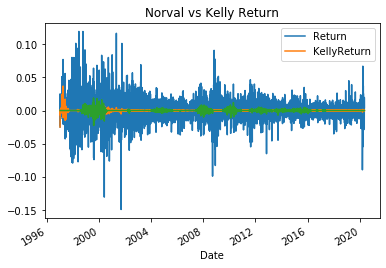

In [28]:
df['Return'].plot(legend=True)
df['KellyReturn'].plot(title='Norval vs Kelly Return',legend=True)
df['52주 KellyReturn'].plot()

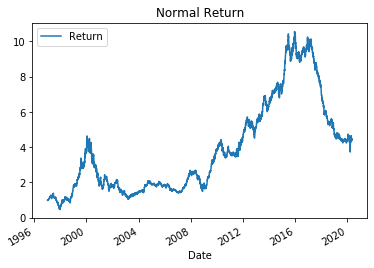

In [29]:
(df['Return']+1).cumprod().plot(legend=True,title='Normal Return')

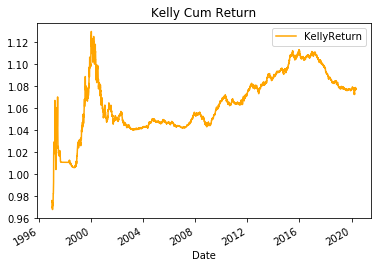

In [30]:
(df['KellyReturn']+1).cumprod().plot(legend=True,title='Kelly Cum Return',color='orange')

C:\Users\KMS\Anaconda3\envs\data37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KMS\Anaconda3\envs\data37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)


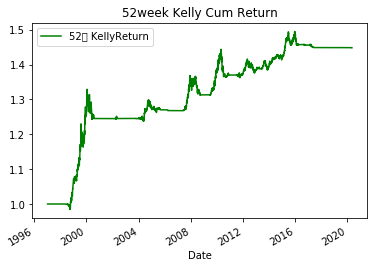

In [31]:
#확실히 급락장에서 배팅을 막아주는 효과 있음
(df['52주 KellyReturn']+1).cumprod().plot(legend=True,title='52week Kelly Cum Return',color='green')

4. pyfolio 이용 백테스트 결과

In [32]:
import pyfolio as pf

C:\Users\KMS\Anaconda3\envs\data37\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\KMS\Anaconda3\envs\data37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [33]:
pf.create_returns_tear_sheet(df['Return'])

Start date,1997-01-06
End date,2020-05-08
Total months,278
,Backtest
Annual return,6.6%
Cumulative returns,344.8%
Annual volatility,25.9%
Sharpe ratio,0.38
Calmar ratio,0.09
Stability,0.70
Max drawdown,-77.4%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [34]:
pf.create_returns_tear_sheet(df['KellyReturn'])

Start date,1997-01-06
End date,2020-05-08
Total months,278
,Backtest
Annual return,0.3%
Cumulative returns,7.7%
Annual volatility,1.9%
Sharpe ratio,0.17
Calmar ratio,0.04
Stability,0.54
Max drawdown,-7.9%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [35]:
pf.create_returns_tear_sheet(df['52주 KellyReturn'])

Start date,1997-01-06
End date,2020-05-08
Total months,278
,Backtest
Annual return,1.6%
Cumulative returns,44.8%
Annual volatility,2.8%
Sharpe ratio,0.59
Calmar ratio,0.23
Stability,0.80
Max drawdown,-6.9%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

## 결론
확실히 캘리 베팅은 하락장을 감지하고 베팅사이즈 축소를 유도해주는 효과가 있는 것 같다